<a href="https://colab.research.google.com/github/dhruv20047228/LLM/blob/main/pretraining_on_unlabeled_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tiktoken
!pip install tensorflow

In [ ]:

from importlib.metadata import version

pkgs = ["matplotlib",
        "numpy",
        "tiktoken",
        "torch",
        "tensorflow"]
for p in pkgs:
  print(f"{p} version: {version(p)}")

#**Evaluating generative text models**

In [ ]:
#Using GPT to generate text
import torch
from previous import GPTModel
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();


In [ ]:
import tiktoken
from previous import generate_text_simple

def text_to_token_ids(text, tokenizer):
  encoded = tokenizer.encode(text, allowed_special={'<|enfoftext|>'})
  encoded_tensor = torch.tensor(encoded).unsqueeze(0)
  return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
  flat = token_ids.squeeze(0)
  return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("cl100k_base")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

#Calculation of text generation loss

In [ ]:
inputs = torch.tensor([[16833, 3626, 6100],
                       [40, 1107, 588]])

targets = torch.tensor([[3626, 6100, 345],
                        [1107, 588, 11311]])


In [ ]:
with torch.no_grad():
  logits = model(inputs)

probas = torch.softmax(logits, dim=-1)
print(probas.shape)

In [ ]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

In [ ]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Output batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

In [ ]:
#token probabilities according to target indices
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

In [ ]:
#compute algo for token probabilities
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

In [ ]:
#average log probability
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

In [ ]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

In [ ]:
print("Logits shape: ", logits.shape)
print("Targets shape:", targets.shape)

In [ ]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("Flattened logits: ", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

In [ ]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

In [ ]:
perplexity = torch.exp(loss)
print(perplexity)

#Calculation of training and validation set losses

In [ ]:

import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

In [ ]:
print(text_data[:99])

In [ ]:
print(text_data[-99:])

In [ ]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:",total_tokens)

In [ ]:
from previous import create_dataloader_v1

train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [ ]:
#Sanity check = either the output is as expectations or not
if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
  print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")
if total_tokens * (1-train_ratio) < GPT_CONFIG_124M['context_length']:
  print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

In [ ]:
#optional check either the data is properly loaded or not
print("Train loader:")
for x,y in train_loader:
  print(x.shape, y.shape)

print("\nValidation loader:")
for x,y in val_loader:
  print(x.shape, y.shape)

In [ ]:
#optional check either token size are in the expected ball park or not
train_tokens = 0
for input_batch, target_batch in train_loader:
  train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
  val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

In [ ]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [ ]:
#only if you have device which can run with CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
torch.manual_seed(123)

with torch.no_grad():
  train_loss = calc_loss_loader(train_loader, model, device)
  val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

#**Training an LLM**

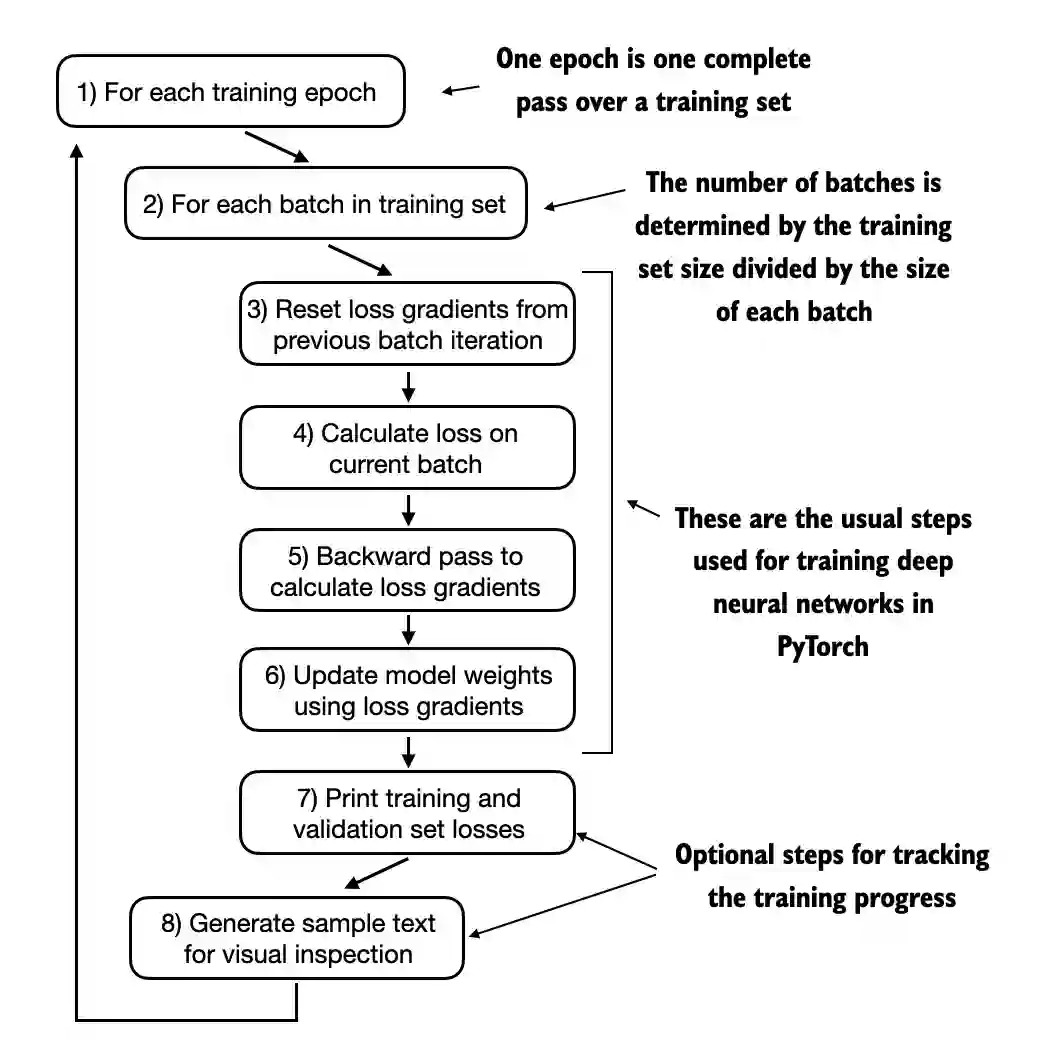

In [ ]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded, # Changed 'input_ids' to 'idx'
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [ ]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
  fig, ax1 = plt.subplots(figsize=(5, 3))

  ax1.plot(epochs_seen, train_losses, label="Training loss")
  ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
  ax1.set_xlabel("Epochs")
  ax1.set_ylabel("Loss")
  ax1.legend(loc="upper right")
  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

  ax2 = ax1.twiny()
  ax2.plot(tokens_seen, train_losses, alpha=0)
  ax2.set_xlabel("Tokens seen")

  fig.tight_layout()
  plt.savefig("loss-plot.pdf")
  plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

#**Strategies to control randomness**

In [ ]:
model.to("cpu")
model.eval()

tokenizer = tiktoken.get_encoding("cl100k_base")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Ever effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

#Temperature scaling

In [ ]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}
inverse_vocab = {v: k for k, v in vocab.items()}

next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()

print(inverse_vocab[next_token_id])

In [ ]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

In [ ]:
def print_sampled_tokens(probas):
  torch.manual_seed(123)
  sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
  sampled_ids = torch.bincount(torch.tensor(sample), minlength=len(probas))
  for i, freq in enumerate(sampled_ids):
    print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

In [ ]:
def softmax_with_temperature(logits, temperature):
  scaled_logits = logits / temperature
  return torch.softmax(scaled_logits, dim=0)

temperatures = [1, 0.1, 5]
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

In [ ]:
#Plotting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5,3))
for i, T in enumerate(temperatures):
  rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f"Temperature = {T}")

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

In [ ]:
print_sampled_tokens(scaled_probas[1])

In [ ]:
print_sampled_tokens(scaled_probas[2])

#Top k-sampling

In [ ]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)

print("Top logits:", top_logits)
print("Top positions:", top_pos)


In [ ]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float("-inf")),
    other=next_token_logits
)

print(new_logits)

In [ ]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

#Modification of text generation function

In [ ]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

  for _ in range(max_new_tokens):
    idx_cond = idx[:, -context_size:]
    with torch.no_grad():
      logits = model(idx_cond)
    logits = logits[:, -1, :]

    if top_k is not None:
      top_logits, _ = torch.topk(logits, top_k)
      min_val = top_logits[:, -1]
      logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

    if temperature > 0.0:
      logits = logits / temperature

      probs = torch.softmax(logits, dim=-1)

      idx_next = torch.multinomial(probs, num_samples=1)

    else :
      idx_next = torch.argmax(logits, dim=-1, keepdim=True)

    if idx_next == eos_id:
      break

    idx = torch.cat((idx, idx_next), dim=1)

  return idx

In [ ]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M['context_length'],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

#**Loading and saving model weights in Pytorch**

In [ ]:
torch.save(model.state_dict(), "model.pth")

In [ ]:
model = GPTModel(GPT_CONFIG_124M)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("model.pth", map_location=device, weights_only=True))
model.eval()

In [ ]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
},
           "model_and_optimizer.pth"
           )

In [ ]:
checkpoint = torch.load("model_and_optimizer.pth", weights_only=True)

model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

#**Loading pretrained weights from OpenAI**

In [ ]:
file_name = "gpt2-small-124M.pth"
# file_name = "gpt2-medium-355M.pth"
# file_name = "gpt2-large-774M.pth"
# file_name = "gpt2-xl-1558M.pth"

url = f"https://huggingface.co/rasbt/gpt2-from-scratch-pytorch/resolve/main/{file_name}"

if not os.path.exists(file_name):
    urllib.request.urlretrieve(url, file_name)
    print(f"Downloaded to {file_name}")

gpt = GPTModel(BASE_CONFIG)
gpt.load_state_dict(torch.load(file_name, weights_only=True))
gpt.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpt.to(device);


torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))